# Notes from Christopher Bishop's <b>Pattern Recognition and Machine Learning</b>

## Some notes I decided to take in notebook form, including code examples, visualizations, and equations and derviations

In [27]:
%config Completer.use_jedi = False

## Polynomial Curve Fitting

### Generating Training Data

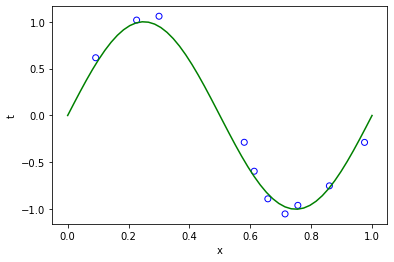

In [28]:
import jax.numpy as np
import math
import matplotlib.pyplot as plt
from jax import jit, grad, vmap, value_and_grad
from jax import random

#Number of points
N = 10
# Generate JAX andom key
key = random.PRNGKey(5)

#Create features
x = random.uniform(key, shape=(N,), minval=0.0, maxval=1)
#Create Labels
y = np.sin(2*math.pi*x)
#Add noise
y = y+random.permutation(key, random.normal(key, shape=(N,)) * 0.1)

#Create sin(2pi*x) function
t_x = np.linspace(0,1)
t_y = np.sin(2*math.pi*t_x)

#Plot
plt.scatter(x, y, facecolors = 'none', edgecolors = 'b')
plt.plot(t_x, t_y,'g-')
plt.xlabel("x")
plt.ylabel("t")
plt.show()

### Fitting Polynomials

finished plotting degree 0 polynomial
finished plotting degree 1 polynomial
finished plotting degree 3 polynomial
finished plotting degree 9 polynomial


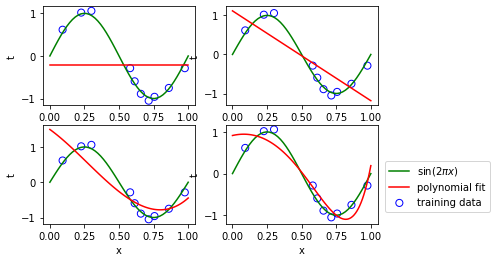

In [29]:
def polynomial(x, weights):
    total = 0
    for j, w in enumerate(weights):
        total += w * x**j
    return total

jit_poly = jit(polynomial)

def SSE(weights, features, targets):
    error = 0
    for x, t in zip(features, targets):
        error += (jit_poly(x, weights) - t)**2
    return 0.5 * error

jit_sse = jit(SSE)

def RMSerror(weights, features, targets):
    return (2*jit_sse(weights, features, targets)/len(targets))**0.5

jit_rmse = jit(RMSerror)

rmse_grad = grad(jit_rmse)
step = .05

W_out = []
M = [0,1,3,9]
for i, m in enumerate(M):
    plt.subplot(2, 2, i + 1)
    W = random.normal(key, shape=(m+1,))

    epochs = 10000
    for i in range(epochs):
        W -= step * rmse_grad(W, x, y)
        
    W_out.append([w for w in W])

    plt.scatter(x, y, facecolors = 'none', edgecolors = 'b', s=50, label='training data')
    plt.plot(t_x, t_y,'g-', label = '$\sin(2\pi x)$')
    plt.plot(np.linspace(0,1,100), [polynomial(i, W) for i in np.linspace(0,1,100)], 'r-', label=f'polynomial fit')
    plt.xlabel("x")
    plt.ylabel("t")
    print(f'finished plotting degree {m} polynomial')
plt.legend(bbox_to_anchor=(1.05,0.64), loc=2, borderaxespad=0.)
plt.show()

## Sanity Baseline

/home/marmar/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


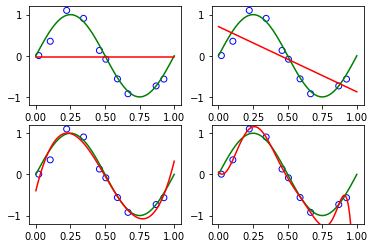

In [12]:
import numpy
x = numpy.random.uniform(0, 1, (N,)).astype('f')
y = numpy.sin(2*math.pi*x)
#Add noise
y = y+numpy.random.permutation(numpy.random.normal(0, 10, (N,)) * 0.01)
for i,m in enumerate([0,1,3,9]):
    plt.subplot(2,2,i+1)
    mymodel = numpy.poly1d(numpy.polyfit(x, y, m))

    myline = numpy.linspace(0, 1, 100)

    plt.scatter(x, y, facecolors = 'none', edgecolors = 'b')
    plt.plot(t_x, t_y,'g-')
    plt.plot(myline, mymodel(myline), 'r-')
    plt.ylim(-1.2,1.2)
plt.show()

In [14]:
x_test = numpy.random.uniform(0,1,(N,)).astype('f')
y_test = numpy.sin(2*math.pi*x_test)
y_test = y_test+numpy.random.permutation(numpy.random.normal(0, 10, (N,)) * 0.01)

def baselineSSE(preds, targets):
    error = 0
    for y, t in zip(preds, targets):
        error += (y - t)**2
    return 0.5 * error

def baselineRMSerror(features, targets):
    return (2*baselineSSE(features, targets)/len(targets))**0.5

np_train_losses = []
np_test_losses = []

for i in range(10):
    mymodel = numpy.poly1d(numpy.polyfit(x, y, i))
    np_train_losses.append(baselineRMSerror(mymodel(x), y))
    preds = [mymodel(x_i) for x_i in x_test]
    np_test_losses.append(baselineRMSerror(preds, y_test))

/home/marmar/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/marmar/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


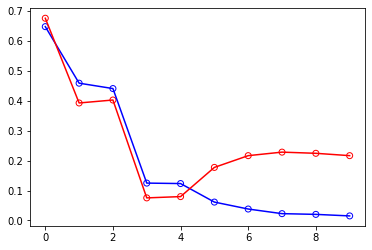

In [15]:
plt.scatter(range(10), np_train_losses, facecolors = 'none', edgecolors = 'b')
plt.scatter(range(10), np_test_losses, facecolors = 'none', edgecolors = 'r')

plt.plot(range(10), np_train_losses, 'b-')
plt.plot(range(10), np_test_losses, 'r-')
plt.show()

## Adding L2 Norm Regularization

In [38]:
W = random.normal(key, shape=(5,))
w2 = W@W.T
print(w2)

3.3742406


In [48]:
l = 1

def reg_SSE(weights, features, targets, l=0.0005):
    error = 0
    for x, t in zip(features, targets):
        error += ((jit_poly(x, weights) - t)**2) + (l/2)*(weights[1:]@weights[1:].T)
    return 0.5 * error

jit_reg_sse = jit(reg_SSE)

def reg_RMSerror(weights, features, targets, l):
    return (2*jit_reg_sse(weights, features, targets, l)/len(targets))**0.5

finished plotting polynomial with lambda of 0.0005
finished plotting polynomial with lambda of 0.005
finished plotting polynomial with lambda of 0.05
finished plotting polynomial with lambda of 0.5


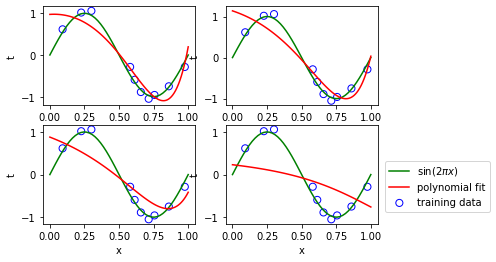

In [49]:
jit_reg_rmse = jit(reg_RMSerror)

rmse_reg_grad = grad(jit_reg_rmse)
step = .05

W_out = []
M = [0,1,3,9]
for i, l in enumerate([0.0005, 0.005, 0.05, 0.5]):
    plt.subplot(2, 2, i + 1)
    W = random.normal(key, shape=(9,))

    epochs = 10000
    for i in range(epochs):
        W -= step * rmse_reg_grad(W, x, y, l)
        
    W_out.append([w for w in W])

    plt.scatter(x, y, facecolors = 'none', edgecolors = 'b', s=50, label='training data')
    plt.plot(t_x, t_y,'g-', label = '$\sin(2\pi x)$')
    plt.plot(np.linspace(0,1,100), [polynomial(i, W) for i in np.linspace(0,1,100)], 'r-', label=f'polynomial fit')
    plt.xlabel("x")
    plt.ylabel("t")
    print(f'finished plotting polynomial with lambda of {l}')
plt.legend(bbox_to_anchor=(1.05,0.64), loc=2, borderaxespad=0.)
plt.show()